# <center>AlzheimersMRI</center>
#### <center>Christian Abbet, Maxime Bohnenblust, Nicolas Masserey </center> 


# 0. Description

**The goal of this project is to analyse brain MRI images in order to diagnose Alzheimer's disease.**

To do so, a dataset constituted of 186 806 brain MRI images from 3013 scans will be used. Each scan consists of 62 layers of the brain. They are already classified in 3 diagnosis:
* Normal : Healthy brain
* MCI : Mild cognitive impairment
* AD : Alzheimer’s disease

The dataset is divided between a training, validation and a test set of respectively 2019, 435 and 469 scans. The dataset is retrieved from Kaggle website and was located on [Kaggle Alzheimers MRI dataset](https://www.kaggle.com/jesseab/alzheimers-mri-deep-learning), however due to unknown reasons, the dataset was removed from the website at the end of december but a complete description can be found on this [github](https://github.com/jbrown81/ADNI_kaggle/blob/master/adni_kaggle.ipynb). Hoewever pepole can [apply here](https://ida.loni.usc.edu/collaboration/access/appApply.jsp?project=ADNI) to get the data directly from University of Southern California.

Our project aims to use the dataset to train a model that will be able to detect if a patient is affected by Alzheimer's disease or not.


# 1. Data Scrapping


## 1.0. Structure USB Key and Local folder
To prevent users to store a huge amount of data on their own laptop an USB key is needed to store all data. User create **settings.ini** file in the local folder (AlzheimersMRI) as shown :


```
AlzheimersMRI (local folder)
│   settings.ini
│   ...
└───run
    │   ...
```
The user **MUST** set path in settings.ini, according to his local settings. The structure of file **settings.ini** is :

```bash
[dataset]
path = /path/to/USB_KEY
```

Concerning USB_KEY, it must have the following structure :

```
USB_KEY
│   adni_demographic_master_kaggle.csv
│
└───MRI
    │   img_array_train_6k_1.npy
    │   ...
    │   img_array_train_6k_22.npy
    │   img_array_valid_6k_1.npy
    │   ...
    │   img_array_valid_6k_5.npy
    │   img_array_test_6k_1.npy
    │   ...
    │   img_array_test_6k_5.npy

```

## 1.1. Loading data

**CSV File** : Load data and display first elements of the lookup table associated to the problem. File adni_demographic_master_kaggle.csv contains multiples fields.
* **train_valid_test** : Field interpreted as 0=Training, 1=Validation, 2=Test
* **only_date** : MRI scan date, as format %Y%m%d (Year, month, day, e.g.: 20051021)
* **diagnosis** : Field interpreted as 1=Normal, 2=MCI(Mild Cognitive Impairment), 3=AD(Alzheimer's Disease)
* **sex** : Field interpreted as : Female = 'F', Male = 'M'
* **age_at_scan** : Age of the patient when MRI scan was performed

Data cleaning in this case means that column are converted to the corresponding type (time or int).

**MRI folder** : It contains all MRI scans of patients. The data set was pre-splitted in 3 subdata sets : Train, Validation and Test sets. Due to large amount of data each sets are stored as \*.npy file. Each \*.npy file contains around 6000 images. Each patient is represented by 62 scans of 96x96 pixels. The scans goes from bottom to top of the brain. 

Note that laptops are not built to handle such huge amout of data. Therefore training is performed with only a part of the scans (one to five scan(s) per patient).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
%reload_ext autoreload
%matplotlib inline

from DataLoader import DataLoader
from CNN import CNN
import configparser

# Read the dataset path according to user settings
settings = configparser.ConfigParser()
settings.read('settings.ini')
os_path = settings.get('dataset', 'path')

In [2]:
# Load Patient and file preview
patients = DataLoader.load_table(os_path=os_path)
DataLoader.clean_data(patients=patients)
patients.head()

train_valid_test  only_date diagnosis sex  age_at_scan
0         TRAINING 2005-10-21       MCI   F      70.9973
1         TRAINING 2005-10-21       MCI   F      70.9973
2         TRAINING 2006-05-18       MCI   F      71.5616
3         TRAINING 2006-05-18       MCI   F      71.5616
4         TRAINING 2006-11-13       MCI   F      72.0603

In [3]:
# Load MRIS (train, validation and test) form dataset and display sizes
id_image = [30, 35, 40, 45, 50]
mris_train = DataLoader.load_MRI_dataset_part_id(os_path=os_path, nbr=22, id_image=id_image, set_type='train')
mris_valid = DataLoader.load_MRI_dataset_part_id(os_path=os_path, nbr=5, id_image=id_image, set_type='valid')
mris_test = DataLoader.load_MRI_dataset_part_id(os_path=os_path, nbr=5, id_image=id_image, set_type='test')

print('Final shape train=', mris_train.shape)
print('Final shape valid=', mris_valid.shape)
print('Final shape test=', mris_test.shape)

Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_1.npy  ... current images= 0
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_2.npy  ... current images= 484
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_3.npy  ... current images= 966
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_4.npy  ... current images= 1450
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_5.npy  ... current images= 1935
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_6.npy  ... current images= 2420
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_7.npy  ... current images= 2902
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_8.npy  ... current images= 3385
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_9.npy  ... current images= 3870
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_10.npy  ... current images= 4355
Loading... /media/sf_AlzheimersMRIdata/MRI/img_array_train_6k_11

## 1.2. Data analysis / visualization

Data is analysed according to:
* (a) - Gender and diagnosis repartitions.
* (b) - Patients age repartition for each diagnosis. Patient with Normal diagnosis are less spread along age (smaller variance). Note that there is an homogenous repartition of genders for each diagnosis.
* (c) - Shows the repartition of scans over time. Most of scans were performed during the years 2006-2010. Last scans were performed mid 2014.
* (d) - Shows the repartition of scans over time with patients age and sex. Note that during the period 2011-2014 the patient were older (as show by the linear regression in blue).
* (e) - No apparent correlation between diagnosis and age or diagnosis and sex. This is mainly due to the fact that it is not relevant to do such statistic on such few patient since they do not represent the average population.
* (f) - Display part of the training and validation set. Note that only 5 images are present since only 5 images were loaded per patients

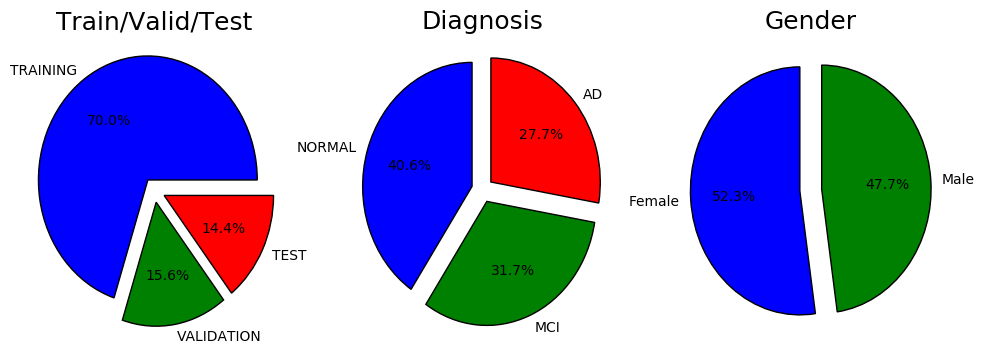

In [4]:
# (a) Gender and Diagnosis repartitions
DataLoader.plot_pie_info(patients=patients)

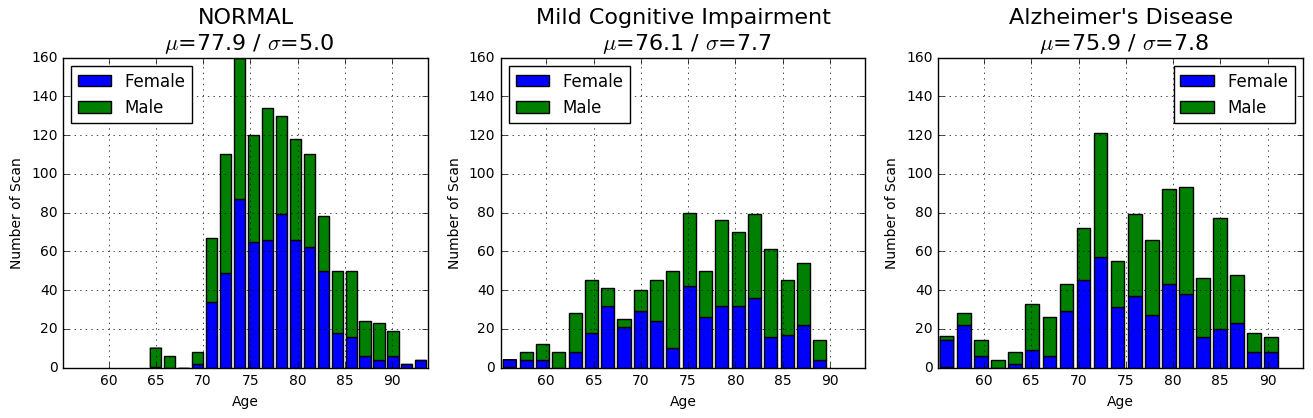

In [5]:
# (b) Patients age repartition for each diagnosis
DataLoader.plot_age_distrib(patients=patients)

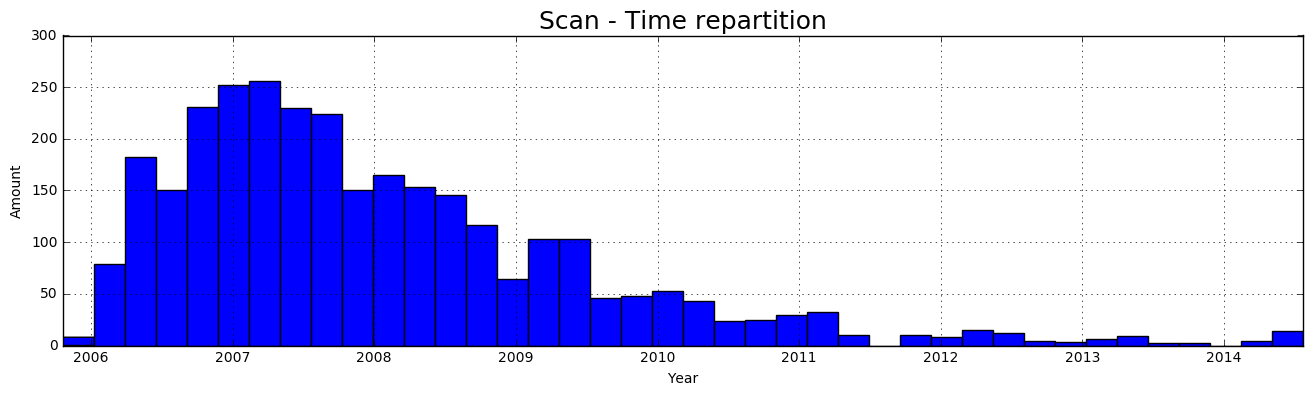

In [6]:
# (c) Scans frequencies over time as an histogram
DataLoader.plot_scan_time_hist(patients=patients)

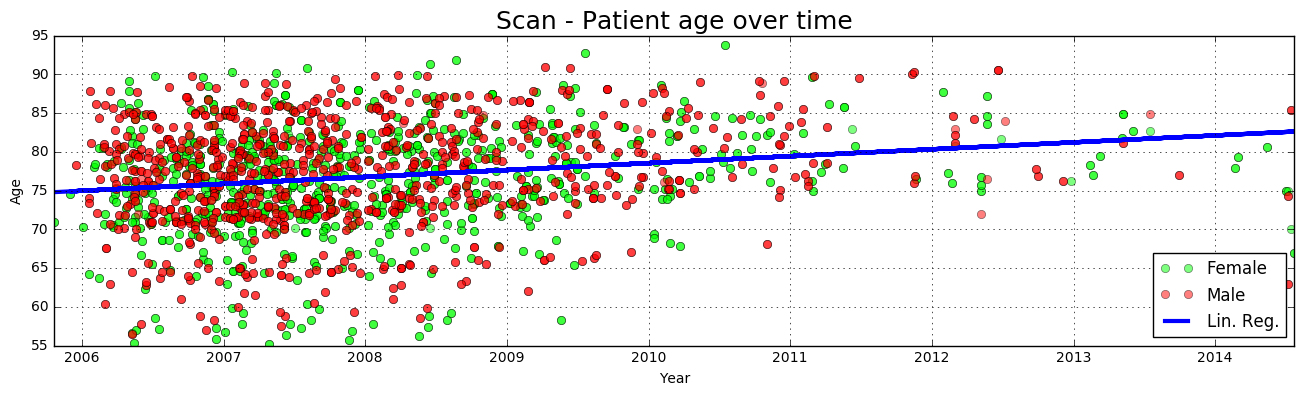

In [7]:
# (d) Display age of patient over time and color indicationg gender
DataLoader.plot_scan_time_age(patients=patients)

In [8]:
# (e) Correlation between diagnosis and age/sex
DataLoader.print_correlation(patients=patients)

Correlation Diagnosis - Age: -0.13
Correlation Diagnosis - Sex: 0.04


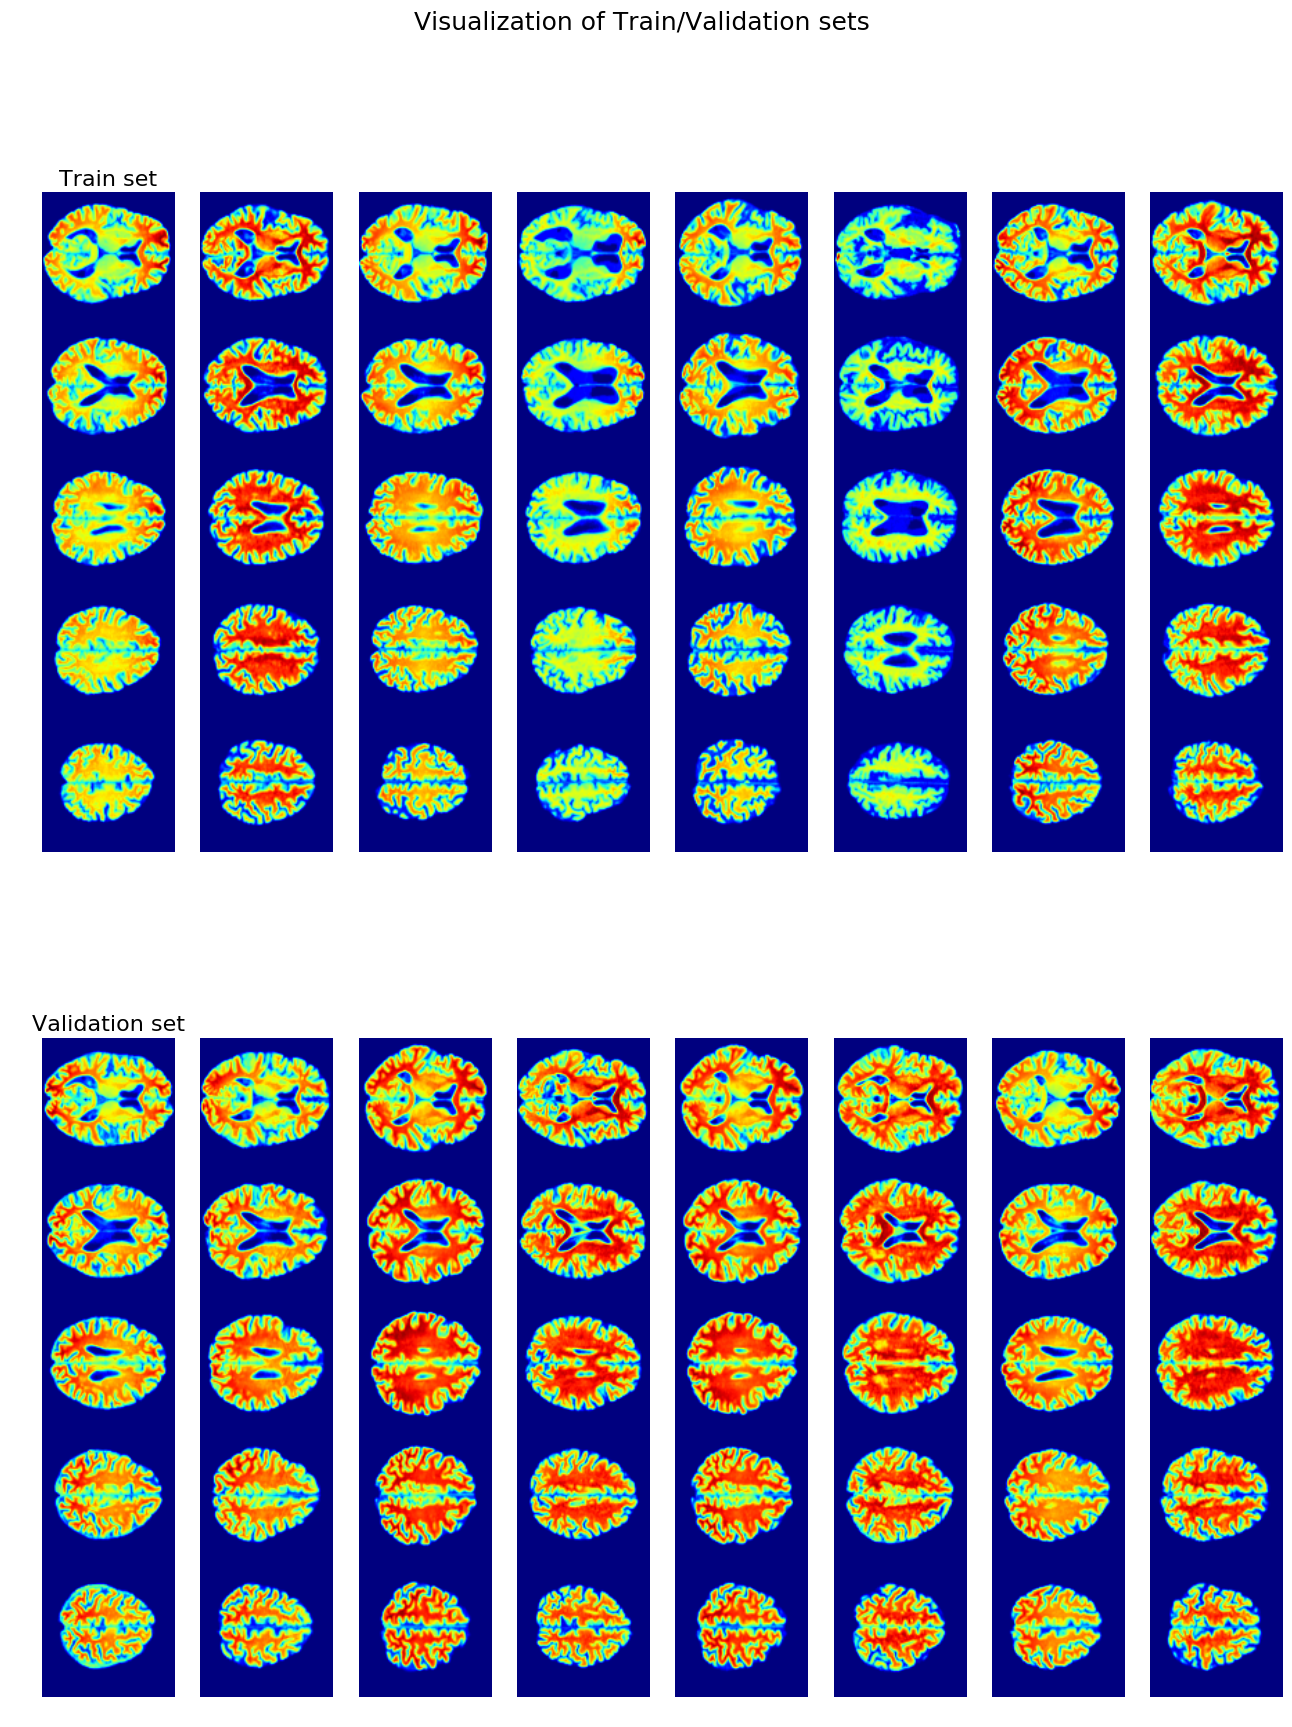

In [9]:
# (f) Sets vizualizations
CNN.plot_sets_preview(train_data=mris_train, valid_data=mris_valid, n_sample = 8)

# 2. Model - Basic CNN - CLx-FC3
The convolutional neural network classifier used in this case is defined as:

$$
y=\textrm{softmax}(ReLU(x\ast W_{CL}+b_{CL})W_{FC}+b_{FC})
$$

Regularized convolutional neural network classifier with the dropout technique (some neurons are randomly set to 0 in the forward pass)

## 2.1 Demo - Basic CNN - CL10-FC3
Here is a demo of the first model that we run with its results displayed. Note that the computation time is high. The results are saved to dummy file 'model_basic_demo.npy'. The result of the run are already displayed below.

* (b) - First plot shows the probality for each point to belong into the corresponding class (ground truth indicated by colors, blue for normal, green for MCI, red for AD). This is the plot of the outcome of the CNN first model. Note that some point are badly classified (e.g. red points=AD in Normal section). This is due to the fact that the accuracy is not 100%. Second plot shows the evolution of accuracy over iteration.
* (c) - Print the accuracy of model on test data

In [10]:
# (a) Get training/validation/traing labels and normalize images
patients = DataLoader.load_table(os_path=os_path)
train_data, train_labels = CNN.get_data(patients, mris_train, batch_size=100, id_train=0, is_one_hot=True)
valid_data, valid_labels = CNN.get_data(patients, mris_valid, batch_size=100, id_train=1, is_one_hot=True)
test_data, test_labels = CNN.get_data(patients, mris_test, batch_size=1, id_train=2, is_one_hot=True)
# Run model
CNN.run_basic_cnn(train_data, train_labels, valid_data, valid_labels,
                  batch_size=100, reg_par=1e-7, learning_rate=1e-3, F=20,
                  n_iter=15000, print_iter=1000, run_name = 'model_basic_demo.npy')



Iteration i= 0 , train accuracy= 0.42 , loss= 1.09871 time spend= 0:00:07.798895
valid accuracy= 0.3275

Iteration i= 1000 , train accuracy= 0.92 , loss= 0.194574 time spend= 0:39:46.021165
valid accuracy= 0.815

Iteration i= 2000 , train accuracy= 0.97 , loss= 0.109413 time spend= 1:20:35.365224
valid accuracy= 0.8475

Iteration i= 3000 , train accuracy= 0.97 , loss= 0.0828721 time spend= 2:00:13.388302
valid accuracy= 0.8475

Iteration i= 4000 , train accuracy= 0.97 , loss= 0.0825789 time spend= 2:39:11.262948
valid accuracy= 0.8025

Iteration i= 5000 , train accuracy= 0.96 , loss= 0.094646 time spend= 3:19:11.853376
valid accuracy= 0.87

Iteration i= 6000 , train accuracy= 0.99 , loss= 0.051015 time spend= 3:59:35.074486
valid accuracy= 0.8725

Iteration i= 7000 , train accuracy= 0.98 , loss= 0.0237326 time spend= 4:42:20.488267
valid accuracy= 0.8475

Iteration i= 8000 , train accuracy= 0.99 , loss= 0.0487534 time spend= 6:13:51.376081
valid accuracy= 0.8575

Iteration i= 9000 , t

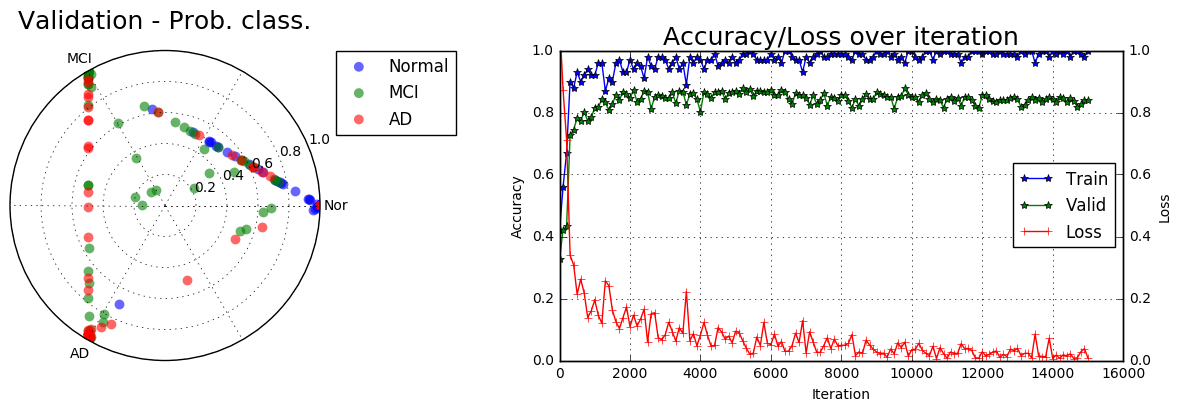

In [11]:
# (b) Plot probability results and accuracy evolution
CNN.plot_cnn_results('model_basic_demo.npy')

In [12]:
# (c) Test learned model on test data
accuracy_test = CNN.apply_basic_cnn(test_data, test_labels, 'model_basic_demo.npy')
print('Test accuracy=', accuracy_test)

Test accuracy= 0.8507


## 2.2 Run model results
Model was tested with different settings. All plots show the evolution of the validation accuracy over iteration.
* **First plot** : Variation of learning rate. As expected if the learning rate is too big the CNN will learn too fast and get stuck below the maximum accuracy it can get. Note that if the learning rate is too slow the CNN will take way too much time to compute the model. A goot value, in this case, is around 1e-3.
* **Second plot** : Variation on filter (convolution layer). There is no signifiant variation on changing the number of filters in this model. The model will just take less iteration to reach convergence. It take around 10000 iteration with F=3 to reach 75% accuracy, but only 5000 with F=15. Also note that run where performed with bigger images (N=3). The more image the more filter is needed to acheive good results.
* **Third plot** : Variation of the regularization parameter. If it is too big the model will converge to lower values. The best results are with a really small regularization term around 1e-7 (even 0).

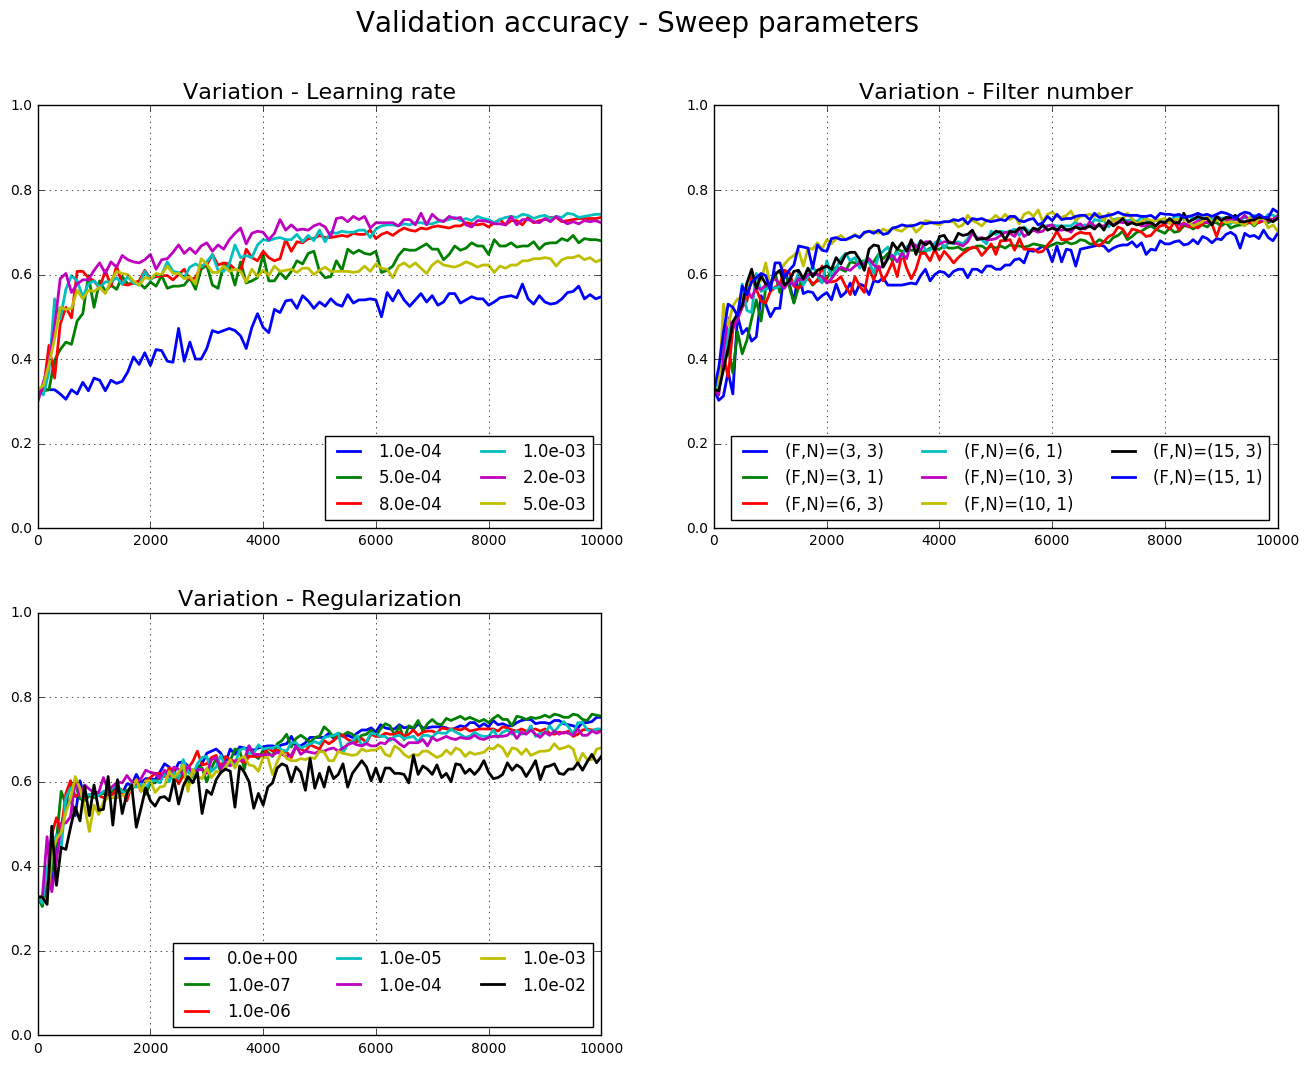

In [13]:
# Run results - plotting sweep settings
CNN.plot_run_resume('basic')

## 2.3 Deconvolution
To see what the CNN learned a deconvolution is used. It allows to see the activation on the image (e.g. zones of interest learned by the network). Using this method two information shows off. The activation are displayed in red. To classify the images, the NN seems to use information on the outer shell of the brain.

References for deconvolution :
* [1] [Deconvolutional Networks](http://www.matthewzeiler.com/pubs/cvpr2010/cvpr2010.pdf). Matthew D. Zeiler, Dilip Krishnan, Graham W. Taylor and Rob Fergus. Dept. of Computer Science, Courant Institute, New York University.

* [2] [Visualizing and Understanding Convolutional Networks](http://www.cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf). Matthew D. Zeiler and Rob Fergus Dept. of Computer Science, New York University, USA


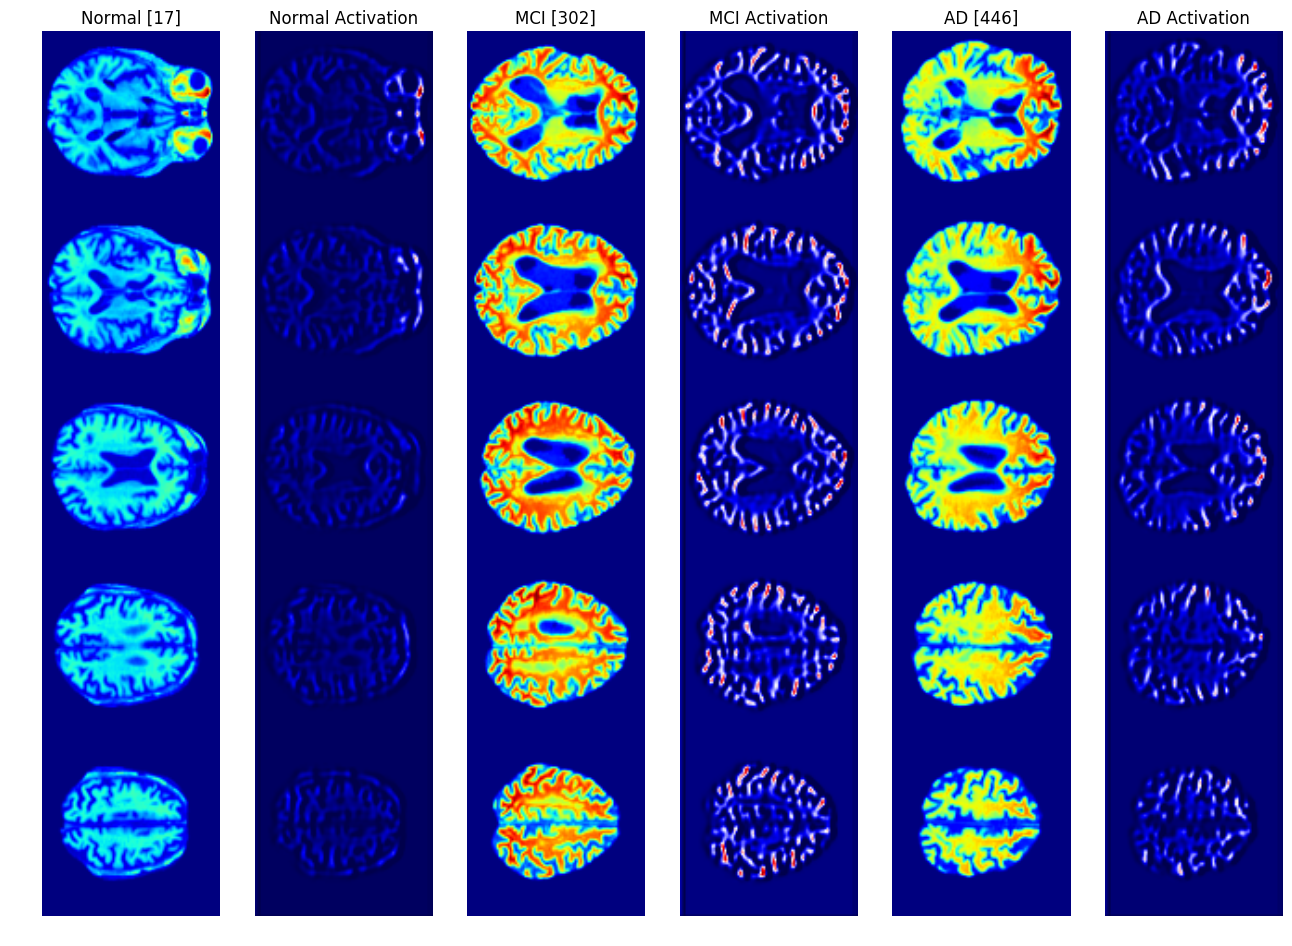

In [14]:
test_data, test_labels = CNN.get_data(patients, mris_test, batch_size=1, id_train=2, is_one_hot=True)
CNN.apply_base_cnn_deconv(test_data, patients, 'model_basic_demo.npy')

# 3. Model - LeNet5 like CNN - CLx-MP4-CLx-MP4-FC512-FC3

## 3.1 Demo - CNN - CL10-MP4-CL20-MP4-FC512-FC3

Here is a demo of the 'LeNet5' model that we implented which can be run and result will be displayed. Not that the computation time is high. The results are saved to dummy file 'model_lenet_demo.npy'. The result of the run are visible below


* (b) - First plot shows the probality of each point to belong to the coresponding class (ground truth indicated by the colors). This is the plot of the outcome of our 'LeNet5' like CNN  model. Note that some point are stilly badly classified but there is no more esitation between AD and Normal cassification. This is really good since the model does not mix up the two state. There is a 'smooth' transision from Normal to MCI and then from MCI to AD.

* (c) - Print the accuracy of model on test data

Note that this model reaches the same accuracy that the basic model, however it needs fewer iterations to do so.

In [15]:
# (a) Get training/validation/traing labels and normalize images
patients = DataLoader.load_table(os_path=os_path)
train_data, train_labels = CNN.get_data(patients, mris_train, batch_size=100, id_train=0, is_one_hot=False)
valid_data, valid_labels = CNN.get_data(patients, mris_valid, batch_size=100, id_train=1, is_one_hot=False)
test_data, test_labels = CNN.get_data(patients, mris_test, batch_size=1, id_train=2, is_one_hot=False)

# Run basic CNN model using loaded data
CNN.run_leNet5_cnn(train_data, train_labels, valid_data, valid_labels,
                   batch_size=100, F1=10, F2=20, reg_par=1e-5, learning_rate=1e-3,
                   n_iter=5000, print_iter=500, drop=0.5,
                   run_name = 'model_lenet_demo.npy')


Iteration i= 0 , train accuracy= 0.49 , loss= 1.11768 time spend= 0:00:07.344208
valid accuracy= 0.3275

Iteration i= 500 , train accuracy= 0.87 , loss= 0.295421 time spend= 0:25:34.270201
valid accuracy= 0.74

Iteration i= 1000 , train accuracy= 0.92 , loss= 0.201471 time spend= 0:52:20.643254
valid accuracy= 0.8425

Iteration i= 1500 , train accuracy= 0.96 , loss= 0.126155 time spend= 1:22:53.758605
valid accuracy= 0.865

Iteration i= 2000 , train accuracy= 0.95 , loss= 0.100786 time spend= 2:01:32.441084
valid accuracy= 0.835

Iteration i= 2500 , train accuracy= 0.96 , loss= 0.146134 time spend= 2:39:43.784370
valid accuracy= 0.8625

Iteration i= 3000 , train accuracy= 0.98 , loss= 0.0846166 time spend= 3:20:36.192459
valid accuracy= 0.86

Iteration i= 3500 , train accuracy= 0.95 , loss= 0.108772 time spend= 3:59:52.811686
valid accuracy= 0.8675

Iteration i= 4000 , train accuracy= 0.97 , loss= 0.0628771 time spend= 4:39:56.196391
valid accuracy= 0.8825

Iteration i= 4500 , train a

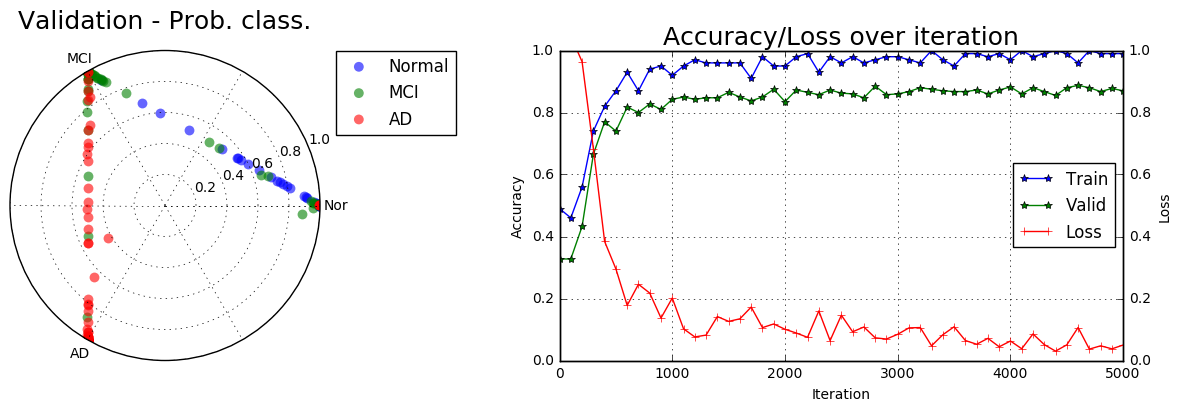

In [16]:
# Plot probability results and accuracy evolution
CNN.plot_cnn_results('model_lenet_demo.npy')

In [17]:
# Test learned model on test data
accuracy_test = CNN.apply_lenet5_cnn(test_data, test_labels, 'model_lenet_demo.npy')
print('Test accuracy =', accuracy_test)

Test accuracy = 0.8401


## 3.2 Run model results

Model was tested with different settings. All plots show the evolution of the validation accuracy over iteration.
* **First plot** : Variation of dropout parameter. With a smaller drop out the accuracy will tend to be a bit better.
* **Second plot** : Variation over N images. One can see that the number of images will change a lot results. Note that for 7 images the results are lower. It does not mean that the model is less efficient with 7 images, it only means that the 7 images choosen in this case were not relevant for the classification.
* **Third plot** : Variation over learning rate. Almost all previous subplots tend to decrease after a while. In this case with a lower learning rate the accuracy stay at a more stable level.
* **Fourth plot** : Variation over regularization. The system tends to give better results with a regularization parameter around 1e-5.  

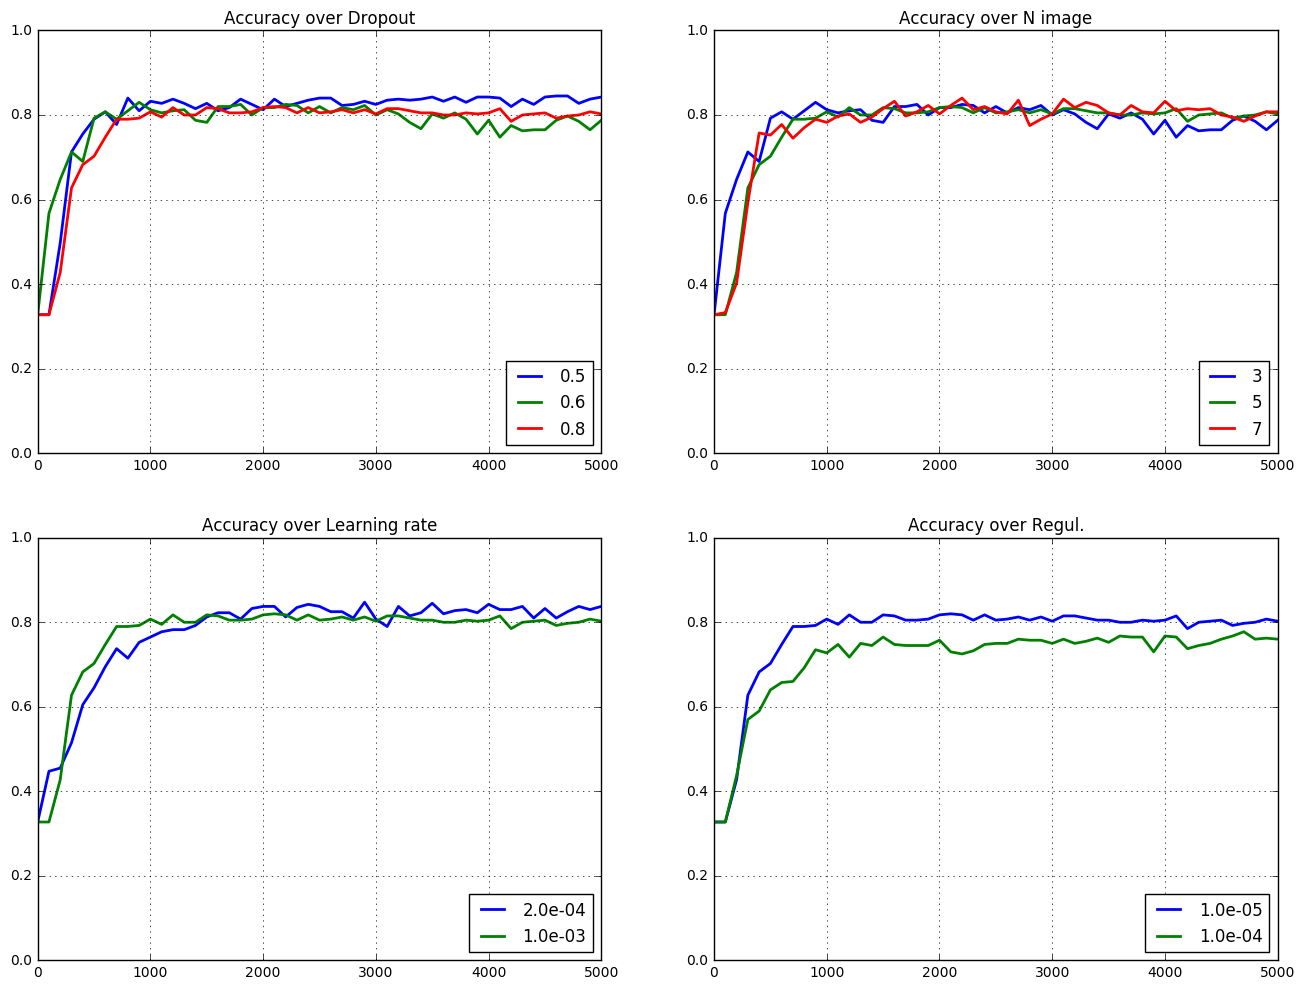

In [18]:
# Run results - plotting sweep settings
CNN.plot_run_resume('lenet5')

## 3.3 Deconvolution
Same deconvolution technique is used on the second CNN. Convolution layer 1 and 2 are shows on (a) and (b). 
* (a) - In the first layer a much larger part of the image is activated. 
* (b) - Concerning second layer, much smaller and specific zone are activated. It seams that the CNN focus on the side of the brain to determine the classification just as the first model did. However the LeNet5 like model will enhance more specific parts of the brain and only on specific layers. 

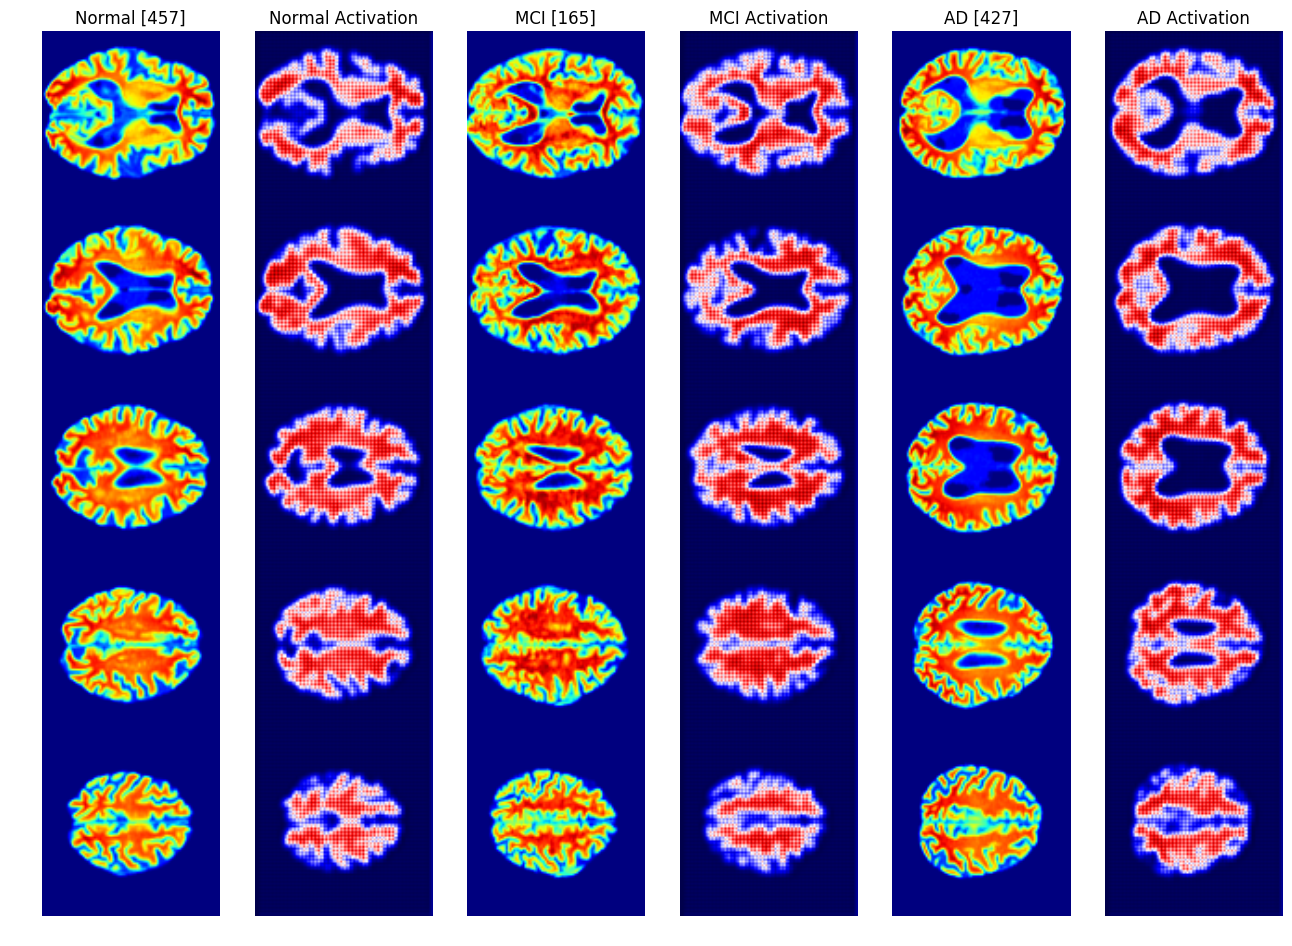

In [19]:
# (a) Shows activation of first convolutional layer
test_data, test_labels = CNN.get_data(patients, mris_test, batch_size=1, id_train=2, is_one_hot=False)
CNN.apply_lenet5_cnn_deconv(test_data, patients, 'model_lenet_demo.npy', id_layer_conv=1)

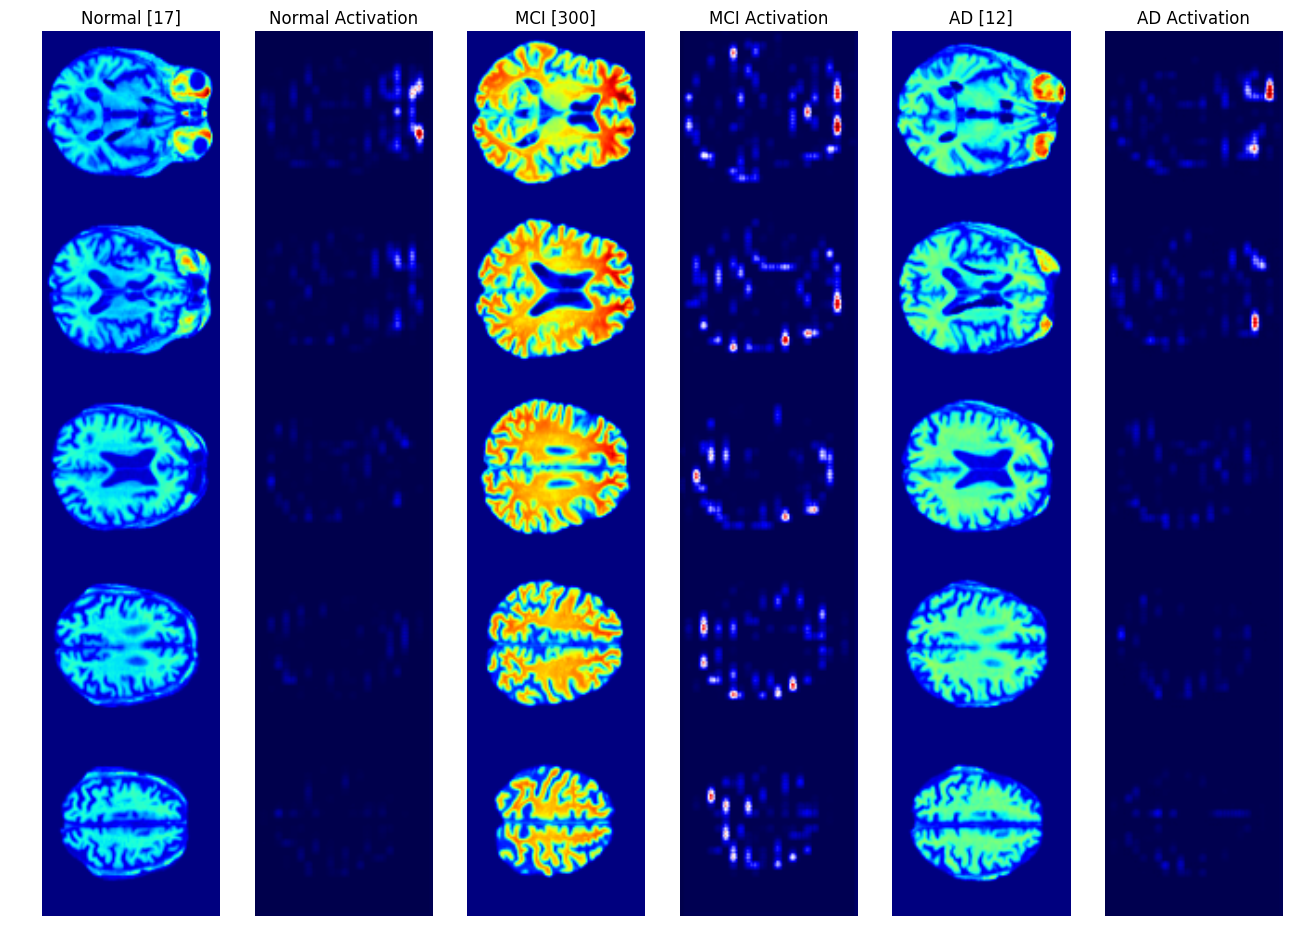

In [20]:
# (b) Shows activation of second convolutional layer
CNN.apply_lenet5_cnn_deconv(test_data, patients, 'model_lenet_demo.npy', id_layer_conv=2)

# 4. Overall resume

As stated previously, we conducted several run with many parameters to find the best one to use. Also, due to computer limitation, we could only use selected images to perform our experiment. For this reason, we took a step by step approach to conduct this project. We started with a basic model and conducted experiment with one image first to see if we had relevant results. Then we added some more images and tried to implement a more complex model in order to achieve the best result possible with the limitation we had.

## 4.1 Basic model

Below is a table regrouping the best results we could achieve with the basic model we implemented. Many run were conducted using only one image, and the limit of an accuracy value of 0.75 was quickly reached.
In order to surpass this limit, a run with 3 images was conducted. The latter proved to be better and atteined a slightly better accuracy value. We implemented then a more complex model on which we focused all our efforts.

Note that the difference of time needed to compute is due to the fact that 3 different computers with different spech were used.

In [21]:
res = CNN.get_basic_resume()
res.head(8)

Accuracy  Accuracy peak  Dropout   F  K  Learning rate  N image  \
23     0.840          0.877     0.25  20  5          0.001      5.0   
15     0.777          0.782     0.25  20  5          0.001      3.0   
9      0.755          0.760     0.25  10  5          0.001      1.0   
12     0.752          0.752     0.25  10  5          0.001      1.0   
20     0.748          0.755     0.25  15  5          0.001      1.0   
7      0.745          0.762     0.25  15  5          0.001      1.0   
6      0.743          0.745     0.25  10  5          0.001      1.0   
18     0.740          0.740     0.25   3  5          0.001      1.0   

    N iteration     Regul.  Time h  
23        15000  1.000e-07  11.732  
15        15000  1.000e-07   6.335  
9         10000  1.000e-07   5.283  
12        10000  0.000e+00   5.914  
20        10000  0.000e+00   3.534  
7         15000  1.000e-07   5.141  
6         10000  0.000e+00   5.317  
18        10000  0.000e+00   1.676

## 4.2 LeNet like model

We apprenhended this model knowing that better results were achievable when using more images. We tried using 3 images, 5 and even 7. Again, we conducted many experiments to find the best parameters to use. In this case there are no significant difference between the two models except for the computation times. However this information is not relevant since run were performed on different laptops.

In [22]:
res = CNN.get_lenet_resume()
res.head(8)

Accuracy  Accuracy peak  Dropout  F1  F2  K  Learning rate  N image  \
10     0.870          0.887     0.50  10  20  5      1.000e-03      5.0   
8      0.863          0.887     0.50  10  20  5      1.000e-03      5.0   
6      0.848          0.868     0.50  10  20  5      2.000e-04      5.0   
1      0.843          0.845     0.50  10  20  5      1.000e-03      5.0   
5      0.838          0.848     0.50  15  30  5      2.000e-04      5.0   
2      0.828          0.877     0.50  15  30  5      1.000e-03      5.0   
7      0.807          0.843     0.50  15  30  5      1.000e-03      7.0   
0      0.802          0.820     0.75  10  20  5      1.000e-03      5.0   

    N iteration     Regul.  Time h  
10         5000  1.000e-05   5.886  
8          5000  1.000e-05  10.544  
6          5000  1.000e-05  13.401  
1          5000  1.000e-05   9.564  
5          5000  1.000e-05  12.315  
2          5000  1.000e-05   8.048  
7          5000  1.000e-05  12.545  
0          5000  1.000e-05  10.823

# 5. Next step

Even if the results are good (around 88% accuracy on validation set), the modely can still be improved. 
* The first limitation we faced on personal laptops was computationnal memory. To solve this issue one solution will be to decrease the size of the input images using technics such as maxpooling of mean value.
* Deconvolution was really usefull to determine if the images used were relevant or not for the classification. Results would maybe be improved using other layers of brain images.
* Running such computation on Laptops are tedious. Running CNN on clusters will significatively decrease computational time. 